## AE + Bi-LSTM

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input
from keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
data = pd.read_csv('Datasets/UNSW_NB15_training_set.csv')

In [3]:
# Separate features and target variable
X = data.drop(columns=['label'])
y = data['label']

In [4]:
# Convert categorical features to numeric using LabelEncoder
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

In [5]:
# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
# Define autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 64

In [8]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(input_layer, decoder)

In [9]:
# Compile and train autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, shuffle=True, validation_data=(X_test, X_test),
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.4923 - val_loss: 0.4413
Epoch 2/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.4090 - val_loss: 0.4159
Epoch 3/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.3918 - val_loss: 0.4141
Epoch 4/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.3906 - val_loss: 0.4137
Epoch 5/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.3903 - val_loss: 0.4130
Epoch 6/50
1096/1096 [==============================] - 4s 3ms/step - loss: 0.3902 - val_loss: 0.4131
Epoch 7/50
1096/1096 [==============================] - 3s 3ms/step - loss: 0.3899 - val_loss: 0.4124
Epoch 8/50
1096/1096 [==============================] - 3s 3ms/step - loss: 0.3892 - val_loss: 0.4125
Epoch 9/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.3895 - val_loss: 0.4123
Epoch 10/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.389

In [10]:
# Extract encoded features
encoder = Model(input_layer, encoder)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

1096/1096 [==============================] - 1s 1ms/step


In [11]:
# Reshape data for LSTM input (assuming time steps = 1)
X_train_reshaped = X_train_encoded.reshape(X_train_encoded.shape[0], 1, X_train_encoded.shape[1])
X_test_reshaped = X_test_encoded.reshape(X_test_encoded.shape[0], 1, X_test_encoded.shape[1])


In [12]:
# Define Bi-LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
877/877 [==============================] - 12s 9ms/step - loss: 0.0864 - accuracy: 0.9651 - val_loss: 0.0207 - val_accuracy: 0.9930
Epoch 2/10
877/877 [==============================] - 7s 8ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0104 - val_accuracy: 0.9969
Epoch 3/10
877/877 [==============================] - 7s 8ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 4/10
877/877 [==============================] - 7s 8ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 8.1720e-04 - val_accuracy: 0.9998
Epoch 5/10
877/877 [==============================] - 7s 8ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0039 - val_accuracy: 0.9989
Epoch 6/10
877/877 [==============================] - 7s 8ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 6.0218e-04 - val_accuracy: 0.9999
Epoch 7/10
877/877 [==============================] - 7s 8ms/step - loss: 8.7459e-04 - accuracy: 0.9998 - val_loss: 1.2415e-04 - val_accura

In [15]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

1096/1096 [==============================] - 3s 3ms/step - loss: 1.4592e-04 - accuracy: 0.9999
Test Loss: 0.0001459176273783669, Test Accuracy: 0.99994295835495


## DECISION TREE

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from keras.models import Model
from keras.layers import Input, Dense

In [17]:
# Load the dataset
data = pd.read_csv('Datasets/UNSW_NB15_training_set.csv')

In [18]:
# Exclude non-numeric columns
numeric_cols = data.select_dtypes(include=np.number).columns
X = data[numeric_cols]

In [19]:
# Define the autoencoder architecture
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

In [20]:
# Compile the autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [21]:
# Preprocess the data using the autoencoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=128, shuffle=True)

Epoch 1/10
1370/1370 [==============================] - 3s 2ms/step - loss: 0.7217
Epoch 2/10
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6655
Epoch 3/10
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6615
Epoch 4/10
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6599
Epoch 5/10
1370/1370 [==============================] - 2s 2ms/step - loss: 0.6590
Epoch 6/10
1370/1370 [==============================] - 3s 2ms/step - loss: 0.6585
Epoch 7/10
1370/1370 [==============================] - 2s 2ms/step - loss: 0.6583
Epoch 8/10
1370/1370 [==============================] - 2s 2ms/step - loss: 0.6581
Epoch 9/10
1370/1370 [==============================] - 2s 2ms/step - loss: 0.6579
Epoch 10/10
1370/1370 [==============================] - 2s 2ms/step - loss: 0.6578


In [22]:
# Extract features using the autoencoder
encoder = Model(input_layer, encoded)
X_encoded = encoder.predict(X_scaled)

5480/5480 [==============================] - 7s 1ms/step


In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, data['attack_cat'], test_size=0.2, random_state=42)


In [24]:
# Train a Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
# Evaluate the model
y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test,y_pred_dt))

                precision    recall  f1-score   support

      Analysis       0.21      0.20      0.20       393
      Backdoor       0.08      0.09      0.08       360
           DoS       0.31      0.35      0.33      2370
      Exploits       0.69      0.68      0.68      6772
       Fuzzers       0.72      0.70      0.71      3570
       Generic       0.98      0.98      0.98      8079
        Normal       1.00      1.00      1.00     11169
Reconnaissance       0.55      0.52      0.54      2098
     Shellcode       0.25      0.22      0.23       233
         Worms       0.09      0.12      0.10        25

      accuracy                           0.80     35069
     macro avg       0.49      0.49      0.49     35069
  weighted avg       0.81      0.80      0.81     35069



## GAUSSIAN NAIVE BAYES

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense

In [27]:
# Load the dataset
data = pd.read_csv('Datasets/UNSW_NB15_training_set.csv')

In [28]:
# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns

In [29]:
# One-hot encode categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[categorical_features])
X_encoded = X_encoded.toarray()

In [30]:
# Concatenate encoded categorical features with numerical features
numerical_features = X.select_dtypes(exclude=['object'])
X_encoded = pd.concat([pd.DataFrame(X_encoded), numerical_features], axis=1)

In [31]:
# Convert all column names to strings
X_encoded.columns = X_encoded.columns.astype(str)

In [32]:
# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [33]:
# Define autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_scaled.shape[1])
])

In [34]:
# Compile autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

In [35]:
# Train autoencoder model
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=128, shuffle=True)


Epoch 1/50
1370/1370 [==============================] - 4s 2ms/step - loss: 0.2599
Epoch 2/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0922
Epoch 3/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0622
Epoch 4/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0442
Epoch 5/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0382
Epoch 6/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0342
Epoch 7/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0305
Epoch 8/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0287
Epoch 9/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0307
Epoch 10/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0270
Epoch 11/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0248
Epoch 12/50
1370/1370 [==============================] - 3s 2ms/step - loss: 0.0256
E

In [36]:
# Encode features using autoencoder
X_encoded = autoencoder.predict(X_scaled)

5480/5480 [==============================] - 7s 1ms/step


In [37]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [38]:
# Create Gaussian Naive Bayes model
gnb_model = GaussianNB()

In [39]:
# Train the model
gnb_model.fit(X_train, y_train)

GaussianNB()

In [40]:
# Make predictions
y_pred = gnb_model.predict(X_test)

In [41]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9967492657332687


In [42]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test,y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11169
           1       1.00      1.00      1.00     23900

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069



##  SVM

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [44]:
# Load the dataset
data = pd.read_csv('Datasets/UNSW_NB15_training_set.csv')

In [45]:
# Subset the dataset to 10%
data_subset = data.sample(frac=0.1, random_state=42)

In [46]:
# Exclude non-numeric columns
numeric_cols = data_subset.select_dtypes(include=np.number).columns
X = data_subset[numeric_cols]

In [47]:
# Handle categorical variables (if any)
# For example, label encode the 'attack_cat' column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_subset['attack_cat'])

In [48]:
# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [50]:
# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [51]:
# Make predictions
y_pred = svm_model.predict(X_test)

In [52]:
# Generate classification report
report = classification_report(y_test, y_pred, zero_division = 1)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.18      0.29        49
           1       1.00      0.00      0.00        37
           2       0.33      0.01      0.03       206
           3       0.60      0.90      0.72       675
           4       0.79      0.74      0.76       386
           5       0.98      0.98      0.98       831
           6       1.00      1.00      1.00      1111
           7       0.65      0.58      0.61       195
           8       1.00      0.00      0.00        14
           9       1.00      0.00      0.00         3

    accuracy                           0.84      3507
   macro avg       0.80      0.44      0.44      3507
weighted avg       0.83      0.84      0.81      3507



## SVC-Linear

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from keras.models import Model
from keras.layers import Input, Dense

In [54]:
# Load the dataset
data = pd.read_csv('Datasets/UNSW_NB15_training_set.csv')

In [55]:
# Subset the dataset to 10%
data_subset = data.sample(frac=0.1, random_state=42)

In [56]:
# Exclude non-numeric columns
numeric_cols = data_subset.select_dtypes(include=np.number).columns
X = data_subset[numeric_cols]

In [57]:
# Handle categorical variables (if any)
# For example, label encode the 'attack_cat' column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_subset['attack_cat'])

In [58]:
# Define the autoencoder architecture
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

In [59]:
# Compile the autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [60]:
# Preprocess the data using the autoencoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=128, shuffle=True)

Epoch 1/10
137/137 [==============================] - 1s 2ms/step - loss: 1.0148
Epoch 2/10
137/137 [==============================] - 0s 2ms/step - loss: 0.7573
Epoch 3/10
137/137 [==============================] - 0s 2ms/step - loss: 0.7191
Epoch 4/10
137/137 [==============================] - 0s 2ms/step - loss: 0.7032
Epoch 5/10
137/137 [==============================] - 0s 2ms/step - loss: 0.6939
Epoch 6/10
137/137 [==============================] - 0s 2ms/step - loss: 0.6876
Epoch 7/10
137/137 [==============================] - 0s 2ms/step - loss: 0.6822
Epoch 8/10
137/137 [==============================] - 0s 2ms/step - loss: 0.6789
Epoch 9/10
137/137 [==============================] - 0s 2ms/step - loss: 0.6763
Epoch 10/10
137/137 [==============================] - 0s 2ms/step - loss: 0.6743


In [61]:
# Extract features using the autoencoder
encoder = Model(input_layer, encoded)
X_encoded = encoder.predict(X_scaled)

548/548 [==============================] - 1s 1ms/step


In [62]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [63]:
# Train and evaluate the SVC model with linear kernel
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

In [64]:
# Print classification report
print(classification_report(y_test,y_pred_svc,zero_division = 1))

              precision    recall  f1-score   support

           0       0.60      0.18      0.28        49
           1       1.00      0.00      0.00        37
           2       0.30      0.01      0.03       206
           3       0.58      0.88      0.70       675
           4       0.74      0.67      0.70       386
           5       0.98      0.98      0.98       831
           6       1.00      1.00      1.00      1111
           7       0.56      0.50      0.53       195
           8       1.00      0.00      0.00        14
           9       1.00      0.00      0.00         3

    accuracy                           0.82      3507
   macro avg       0.78      0.42      0.42      3507
weighted avg       0.81      0.82      0.80      3507



## COMPARISON

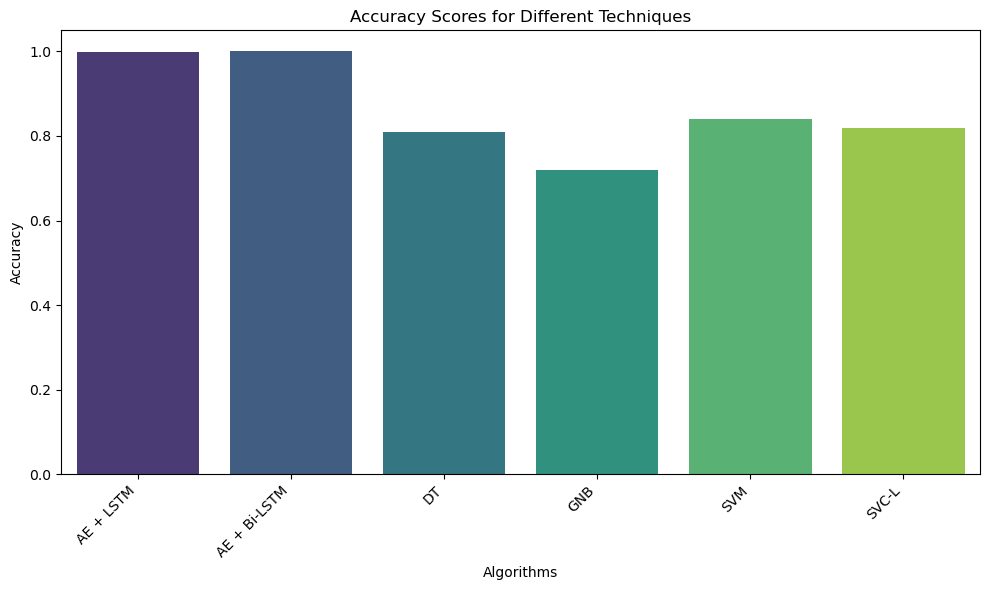

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
algorithms = [
    'AE + LSTM',
    'AE + Bi-LSTM',
    'DT',
    'GNB',
    'SVM',
    'SVC-L',
]

parameters = [
    "Accuracy",
]

scores = [
    [0.9989],
    [0.9999144673347473],
    [0.81],
    [0.72],
    [0.84],
    [0.82]
]

# Create DataFrame
df = pd.DataFrame(scores, columns=parameters, index=algorithms)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=df.index, y=parameters[0], data=df, palette='viridis')
plt.title('Accuracy Scores for Different Techniques')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()